# AI Portfölj 1 – Colab Kontrollpanel

In [91]:
!pip install -q pandas yfinance matplotlib openpyxl requests

from google.colab import drive
drive.mount('/content/drive')

# ====== Paths & konstanter ======
OWNER  = "BOLDT94"
REPO   = "ChatGPT-Micro-Cap-Experiment"
BRANCH = "main"
REPO_RAW = f"https://raw.githubusercontent.com/{OWNER}/{REPO}/{BRANCH}"

BASE_DIR = "/content/drive/MyDrive/AI-portfölj_v.1.0"
HOLDINGS_FILE = f"{BASE_DIR}/Holdings/holdings.csv"
EOD_DIR  = f"{BASE_DIR}/EOD_log"
EOD_FILE = f"{EOD_DIR}/eod_log.csv"

import os; os.makedirs(EOD_DIR, exist_ok=True)

PORTFOLIO_NAME = "AI Portfölj 1"
CURRENCY = "SEK"

print("HOLDINGS_FILE:", HOLDINGS_FILE)
print("EOD_FILE:", EOD_FILE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
HOLDINGS_FILE: /content/drive/MyDrive/AI-portfölj_v.1.0/Holdings/holdings.csv
EOD_FILE: /content/drive/MyDrive/AI-portfölj_v.1.0/EOD_log/eod_log.csv


In [92]:
import pandas as pd, requests, io, re
from datetime import date, timedelta

def fetch_latest_prices(max_back_days=3):
    tried = []
    for k in range(max_back_days):
        d = date.today() - timedelta(days=k)
        url = f"{REPO_RAW}/data/daily/prices_raw_{d.strftime('%Y%m%d')}.csv"
        r = requests.get(url, timeout=20)
        tried.append(url)
        if r.ok and len(r.text) > 50:
            df = pd.read_csv(io.StringIO(r.text))
            print(f"Hämtade direkt: {url} | rader: {len(df)}")
            return df, url

    api = f"https://api.github.com/repos/{OWNER}/{REPO}/contents/data/daily?ref={BRANCH}"
    r = requests.get(api, timeout=20); tried.append(api)
    if r.ok:
        items = r.json()
        cand = []
        for it in items:
            name = it.get("name","")
            m = re.match(r"prices_raw_(\d{8})\.csv$", name)
            if m: cand.append((m.group(1), name))
        if cand:
            cand.sort(reverse=True)
            yyyymmdd, fname = cand[0]
            url = f"{REPO_RAW}/data/daily/{fname}"
            r2 = requests.get(url, timeout=20); tried.append(url)
            if r2.ok and len(r2.text) > 50:
                df = pd.read_csv(io.StringIO(r2.text))
                print(f"Hämtade via API-listning: {url} | rader: {len(df)}")
                return df, url

    raise RuntimeError("Ingen dagsfil hittad.\nTestade:\n- " + "\n- ".join(tried))

prices_raw, src = fetch_latest_prices(3)
print("Källa:", src)
prices_raw.head()


Hämtade direkt: https://raw.githubusercontent.com/BOLDT94/ChatGPT-Micro-Cap-Experiment/main/data/daily/prices_raw_20250903.csv | rader: 11
Källa: https://raw.githubusercontent.com/BOLDT94/ChatGPT-Micro-Cap-Experiment/main/data/daily/prices_raw_20250903.csv


,ticker,close,asof_date,currency,close_sek,source
0,INTRUM.ST,47.799999,2025-09-03,SEK,47.799999,stooq
1,EMBRAC-B.ST,82.070000,2025-09-03,SEK,82.070000,stooq
2,GOMX.ST,12.760000,2025-09-03,SEK,12.760000,stooq
3,PDX.ST,177.300003,2025-09-03,SEK,177.300003,stooq
4,HEXA-B.ST,103.050003,2025-09-03,SEK,103.050003,stooq


In [93]:
import pandas as pd, numpy as np, yfinance as yf

def _last_fx(symbol):
    try:
        h = yf.download(symbol, period="2mo", interval="1d", auto_adjust=False, progress=False)
        col = "Close" if "Close" in h.columns else ("Adj Close" if "Adj Close" in h.columns else None)
        s = h[col].dropna() if col else None
        return float(s.iloc[-1]) if s is not None and not s.empty else None
    except Exception:
        return None

def ensure_close_sek(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "currency" not in out.columns:
        out["currency"] = "SEK"
    out["currency"] = out["currency"].fillna("SEK").astype(str).str.upper().str.strip()

    if "close_sek" in out.columns and out["close_sek"].notna().any():
        need = out["close_sek"].isna()
        if need.any():
            usdsek = _last_fx("SEK=X"); eursek = _last_fx("EURSEK=X")
            fx = {"USD": usdsek, "EUR": eursek}
            out.loc[need, "close_sek"] = out.loc[need].apply(
                lambda r: (r["close"] * fx.get(r["currency"], 1.0)) if pd.notna(r["close"]) else np.nan, axis=1
            )
        return out

    if "close" not in out.columns:
        raise RuntimeError("prices_raw saknar både 'close_sek' och 'close'.")

    usdsek = _last_fx("SEK=X"); eursek = _last_fx("EURSEK=X")
    fx = {"USD": usdsek, "EUR": eursek}
    out["close_sek"] = out.apply(
        lambda r: (r["close"] * fx.get(r["currency"], 1.0)) if pd.notna(r["close"]) else np.nan, axis=1
    )
    return out

prices_raw = ensure_close_sek(prices_raw)
print("✅ prices_raw klar. Kolumner:", list(prices_raw.columns))


✅ prices_raw klar. Kolumner: ['ticker', 'close', 'asof_date', 'currency', 'close_sek', 'source']


In [95]:
import csv, numpy as np, pandas as pd, os, re

def sniff_delimiter(sample_text: str):
    try: return csv.Sniffer().sniff(sample_text, delimiters=";, \t").delimiter
    except Exception: return None

def try_read(path, sep=None, skiprows=0, header=0, encoding=None):
    try:
        return pd.read_csv(path, sep=sep, skiprows=skiprows, header=header, engine="python", encoding=encoding)
    except UnicodeDecodeError:
        return pd.read_csv(path, sep=sep, skiprows=skiprows, header=header, engine="python", encoding="latin-1")

def as_float(x):
    try: return float(str(x).replace(" ", "").replace(",", "."))
    except: return np.nan

# --- Läs holdings från Drive (ALDRIG /content/holdings.csv) ---
assert os.path.exists(HOLDINGS_FILE), f"Saknas: {HOLDINGS_FILE}"

with open(HOLDINGS_FILE, "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

header_idx = None
for i, line in enumerate(lines[:30]):
    if ("Ticker" in line) and ("Antal" in line) and ("Inköpskurs" in line or "Inkopskurs" in line):
        header_idx = i; break

delim = sniff_delimiter("".join(lines[:5])) or ","
skiprows = header_idx if header_idx is not None else 0
df = try_read(HOLDINGS_FILE, sep=delim, skiprows=skiprows, header=0)

df.columns = [str(c).strip() for c in df.columns]
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]
if len(df.columns) == 1 and df.columns[0] not in ("Ticker","Antal","Inköpskurs"):
    df.columns = ["Ticker"]

# Standardisera rubriker
rename_map = {}
for c in list(df.columns):
    c2 = c.strip().replace(" ", "").replace("_", "").lower()
    if c2 == "ticker": rename_map[c] = "Ticker"
    if c2 in ("antal","qty","quantity"): rename_map[c] = "Antal"
    if c2 in ("inköpskurs","inkopskurs","inköp","inkop","buyprice","buy"): rename_map[c] = "Inköpskurs"
    if c2 in ("stop-loss","stoploss","sl"): rename_map[c] = "Stop-loss"
    if c2 in ("tradevolym","tradevolume","size","volym"): rename_map[c] = "TradeVolym"
    if c2 in ("marknadsvärde","marknadsvarde","marketvalue","mv"): rename_map[c] = "Marknadsvärde"
df = df.rename(columns=rename_map)

# --- Extrahera & injicera CASH som pseudo-innehav ---
cash_aliases = {"cash","[cash]","kassa","kontanter","[kassa]","[kontanter]"}
cash_value = 0.0
if "Ticker" in df.columns:
    mask_cash = df["Ticker"].astype(str).str.strip().str.lower().isin(cash_aliases)
    cash_rows = df.loc[mask_cash].copy()
    rest = df.loc[~mask_cash].copy()
else:
    cash_rows = pd.DataFrame(); rest = df

def parse_cash_val(s):
    try: return float(str(s).replace("SEK","").replace("kr","").replace(" ", "").replace(",", "."))
    except: return np.nan

if not cash_rows.empty:
    val = None
    for idx, row in cash_rows.iterrows():
        for col in cash_rows.columns:
            if col == "Ticker": continue
            v = parse_cash_val(row[col])
            if not np.isnan(v): val = v; break
    cash_value = float(val) if val is not None else 0.0

# Bygg holdings-tabell
for col in ["Ticker","Antal","Inköpskurs","Stop-loss","TradeVolym","Marknadsvärde"]:
    if col not in rest.columns: rest[col] = np.nan
holdings = rest[["Ticker","Antal","Inköpskurs","Stop-loss","TradeVolym","Marknadsvärde"]].copy()
holdings["Ticker"] = holdings["Ticker"].astype(str).str.strip()
for col in ["Antal","Inköpskurs"]:
    holdings[col] = holdings[col].apply(as_float)

# Lägg in CASH-rad
if cash_value and cash_value > 0:
    cash_row = {"Ticker":"CASH","Antal":cash_value,"Inköpskurs":1.0,"Stop-loss":"","TradeVolym":np.nan,"Marknadsvärde":cash_value}
    holdings = pd.concat([holdings, pd.DataFrame([cash_row])], ignore_index=True)

# --- Städ spillrader (t.ex. "[Cash]", "5000 SEK") ---
def is_spill_ticker(t):
    s = str(t).strip().lower()
    if s == "cash": return False
    if "sek" in s or "kr" in s: return True
    s_digits = re.sub(r"[ ,.\u00A0]", "", s)
    return s_digits.isdigit() or s in {"[cash]","[kassa]","[kontanter]"}
holdings = holdings.loc[~holdings["Ticker"].apply(is_spill_ticker)].reset_index(drop=True)

# --- MERGE (exakt en gång) ---
if "close_sek" in holdings.columns:
    holdings = holdings.drop(columns=["close_sek"])
px = prices_raw.rename(columns={"ticker":"Ticker"}).copy()
px["Ticker"] = px["Ticker"].astype(str).str.strip()
holdings["Ticker"] = holdings["Ticker"].astype(str).str.strip()

holdings = holdings.merge(px[["Ticker","close_sek"]], on="Ticker", how="left", suffixes=("", "_from_px"))
if "close_sek_from_px" in holdings.columns:
    holdings["close_sek"] = holdings["close_sek_from_px"]
    holdings = holdings.drop(columns=["close_sek_from_px"])

# CASH = 1.0 SEK
m_cash = holdings["Ticker"].astype(str).str.upper().eq("CASH")
holdings.loc[m_cash, "close_sek"] = 1.0

# Marknadsvärde
holdings["Antal"] = pd.to_numeric(holdings["Antal"], errors="coerce")
holdings["close_sek"] = pd.to_numeric(holdings["close_sek"], errors="coerce")
holdings["Marknadsvärde"] = (holdings["Antal"] * holdings["close_sek"]).fillna(0.0)

print("✅ Holdings redo")
display(holdings.head(10))


✅ Holdings redo


,Ticker,Antal,Inköpskurs,Stop-loss,TradeVolym,Marknadsvärde,close_sek
0,CASH,5000.0,1.0,,NaN,5000.0,1.0


In [96]:
import pandas as pd, numpy as np

def stop_hit(row):
    if str(row["Ticker"]).upper() == "CASH":  # aldrig SL på cash
        return False
    sl = str(row.get("Stop-loss","")).strip()
    price, buy = row["close_sek"], row["Inköpskurs"]
    if pd.isna(price) or pd.isna(buy): return False
    if sl.endswith("%"):
        try: p = float(sl[:-1].replace(",", ".").strip()) / 100.0
        except: return False
        return price <= (1 - p) * buy
    try:
        return price <= float(sl.replace(",", "."))
    except:
        return False

holdings["StopLossTriggad"] = holdings.apply(stop_hit, axis=1)
print("Stop-loss triggar:", int(holdings["StopLossTriggad"].sum()))


Stop-loss triggar: 0


In [97]:
print("== HOLDINGS DEBUG ==")
print("Kolumner:", list(holdings.columns))
print(holdings)

print("\nSummering:")
print("Antal rader:", len(holdings))
print("Summa Marknadsvärde:", holdings["Marknadsvärde"].sum())


== HOLDINGS DEBUG ==
Kolumner: ['Ticker', 'Antal', 'Inköpskurs', 'Stop-loss', 'TradeVolym', 'Marknadsvärde', 'close_sek', 'StopLossTriggad']
  Ticker   Antal  Inköpskurs Stop-loss  TradeVolym  Marknadsvärde  close_sek  \
0   CASH  5000.0         1.0                   NaN         5000.0        1.0   

   StopLossTriggad  
0            False  

Summering:
Antal rader: 1
Summa Marknadsvärde: 5000.0


In [98]:
# === E8 — EOD-upsert (robust + extra kontroller) ===
from datetime import date
import pandas as pd, numpy as np, os

assert 'holdings' in globals(), "holdings saknas – kör holdings/merge-cellerna först."
assert 'EOD_FILE' in globals() and 'PORTFOLIO_NAME' in globals(), "EOD_FILE/PORTFOLIO_NAME saknas."

def ensure_eod_schema(df: pd.DataFrame) -> pd.DataFrame:
    cols = ["date","day_tag","portfolio_name","cash_SEK","total_value_SEK","notes"]
    if df is None or df.empty:
        return pd.DataFrame(columns=cols)
    for c in cols:
        if c not in df.columns:
            df[c] = np.nan
    return df[cols]

def ensure_eod_file(path: str):
    if not os.path.exists(path):
        ensure_eod_schema(pd.DataFrame()).to_csv(path, index=False)

def upsert_eod(path: str, portfolio_name: str, total_value: float, notes: str = ""):
    ensure_eod_file(path)
    df = pd.read_csv(path) if os.path.exists(path) else pd.DataFrame()
    df = ensure_eod_schema(df)

    # Cash från CASH-raden (pseudo-innehavet)
    cash_detected = 0.0
    if "Ticker" in holdings.columns:
        m = holdings["Ticker"].astype(str).str.upper().eq("CASH")
        if m.any():
            cash_detected = float(holdings.loc[m, "Marknadsvärde"].sum())

    today = date.today().isoformat()
    row = {
        "date": today,
        "day_tag": f"Dag – {today}",
        "portfolio_name": portfolio_name,
        "cash_SEK": float(cash_detected),
        "total_value_SEK": float(total_value),
        "notes": notes,
    }

    # Uppdatera/append kolumn-för-kolumn (undviker pandas-assign fel)
    mask = (df["date"] == today)
    if mask.any():
        idx = df.index[mask][0]
        for k, v in row.items():
            df.at[idx, k] = v
    else:
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)

    df.to_csv(path, index=False)
    return df

# --- Beräkna och skriv dagens rad ---
total_value_sek = float(holdings["Marknadsvärde"].sum()) if not holdings.empty else 0.0
n_stop = int(holdings.get("StopLossTriggad", pd.Series(dtype=bool)).sum()) if not holdings.empty else 0

# Helpful warning om något ser fel ut
has_cash = ("Ticker" in holdings.columns) and holdings["Ticker"].astype(str).str.upper().eq("CASH").any()
cash_mv = float(holdings.loc[holdings["Ticker"].astype(str).str.upper().eq("CASH"), "Marknadsvärde"].sum()) if has_cash else 0.0
if has_cash and (cash_mv > 0) and total_value_sek == 0:
    print("⚠️  Varning: CASH finns men total_value blev 0. Kontrollera holdings/merge.")

eod = upsert_eod(EOD_FILE, PORTFOLIO_NAME, total_value_sek, notes=f"Stop-loss triggar: {n_stop}")
print(f"EOD uppdaterad. Cash: {cash_mv:,.2f} SEK | Total: {total_value_sek:,.2f} SEK | Stop-loss: {n_stop}")
display(eod.tail())


EOD uppdaterad. Cash: 5,000.00 SEK | Total: 5,000.00 SEK | Stop-loss: 0


,date,day_tag,portfolio_name,cash_SEK,total_value_SEK,notes
0,2025-09-03,Dag – 2025-09-03,AI Portfölj 1,5000.0,5000.0,Stop-loss triggar: 0


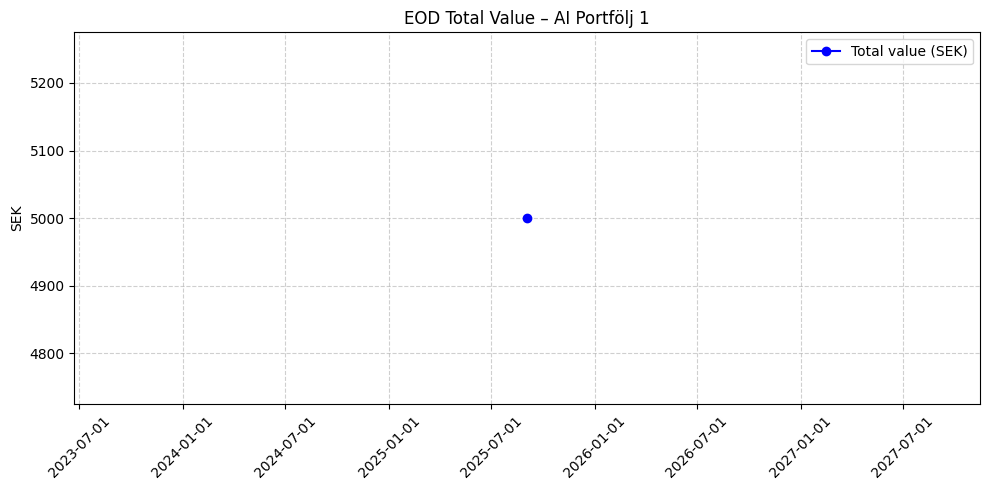

✅ Graf sparad till: /content/drive/MyDrive/AI-portfölj_v.1.0/EOD_log/eod_chart.png


In [101]:
# E9++ — Graf med röda pilar för stop-loss och export till Drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import os

# 1) Läs EOD-logg
df = pd.read_csv(EOD_FILE, parse_dates=["date"])

def extract_sl_count(text: str) -> int:
    if not isinstance(text, str):
        return 0
    m = re.search(r"stop[-\s]?loss\s+triggar:\s*(\d+)", text, flags=re.I)
    return int(m.group(1)) if m else 0

df["sl_count"] = df["notes"].apply(extract_sl_count)
df["sl_flag"]  = df["sl_count"] > 0

# 2) Rita huvudserien
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df["date"], df["total_value_SEK"], marker="o", linestyle="-", label="Total value (SEK)", color="blue")

# 3) Markera SL-dagar med pilar
sl_df = df[df["sl_flag"]].copy()
if not sl_df.empty:
    ax.scatter(sl_df["date"], sl_df["total_value_SEK"], s=80, marker="v", color="red", label="Stop-loss")
    for _, r in sl_df.iterrows():
        ax.annotate(f'SL:{int(r["sl_count"])}',
                    (r["date"], r["total_value_SEK"]),
                    textcoords="offset points", xytext=(0,-15), ha='center',
                    fontsize=9, color="red")

# 4) Styling
ax.set_title(f"EOD Total Value – {PORTFOLIO_NAME}")
ax.set_ylabel("SEK")
ax.grid(True, linestyle="--", alpha=0.6)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
ax.legend()
plt.tight_layout()

# 5) Export till Drive
out_path = os.path.join(BASE_DIR, "EOD_log", "eod_chart.png")
plt.savefig(out_path, dpi=150)
plt.show()

print(f"✅ Graf sparad till: {out_path}")
